In [ ]:
pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b27dd405b59e6aa595c90012425816f5d197ab7b4d061526fa199f93d5690fd1
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
pip install openai==0.28


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.101.0
    Uninstalling openai-1.101.0:
      Successfully uninstalled openai-1.101.0


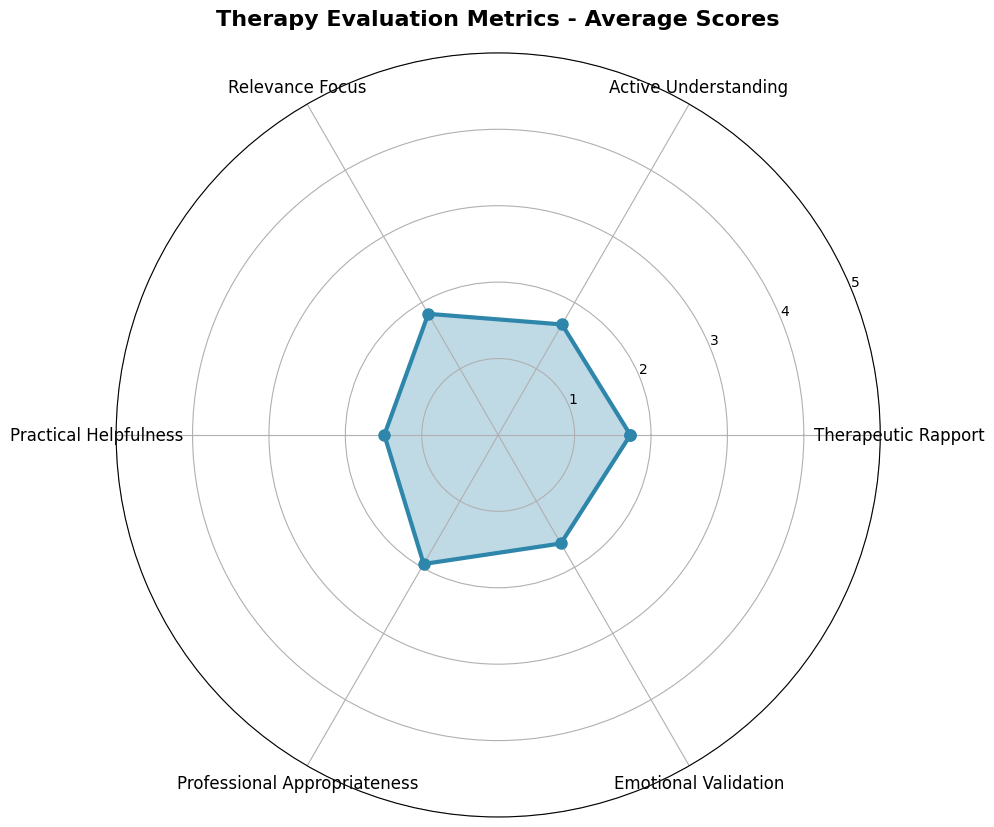

Average Scores for Each Metric:
Therapeutic Rapport: 1.73
Active Understanding: 1.67
Relevance Focus: 1.83
Practical Helpfulness: 1.49
Professional Appropriateness: 1.95
Emotional Validation: 1.64

Overall Average Score: 1.72
Total Samples: 100


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

def create_therapy_radar_chart(csv_file_path):
    """
    Creates a radar chart showing average scores for therapeutic evaluation metrics
    """

    df = pd.read_csv(csv_file_path)

    score_columns = [
        'Therapeutic_Rapport_score',
        'Active_Understanding_score',
        'Relevance_Focus_score',
        'Practical_Helpfulness_score',
        'Professional_Appropriateness_score',
        'Emotional_Validation_score'
    ]

    avg_scores = []
    metric_names = []

    for col in score_columns:
        avg_score = df[col].mean()
        avg_scores.append(avg_score)
        clean_name = col.replace('_score', '').replace('_', ' ')
        metric_names.append(clean_name)

    N = len(metric_names)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  

    avg_scores += avg_scores[:1]

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    ax.plot(angles, avg_scores, 'o-', linewidth=3, color='#2E86AB', markersize=8)
    ax.fill(angles, avg_scores, alpha=0.3, color='#2E86AB')

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_names, fontsize=12)
    ax.set_ylim(0, 5)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1', '2', '3', '4', '5'], fontsize=10)
    ax.grid(True)

    plt.title('Therapy Evaluation Metrics - Average Scores',
              size=16, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

    print("Average Scores for Each Metric:")
    print("=" * 40)
    for name, score in zip(metric_names, avg_scores[:-1]):
        print(f"{name}: {score:.2f}")
    print(f"\nOverall Average Score: {df['average_score'].mean():.2f}")
    print(f"Total Samples: {len(df)}")

if __name__ == "__main__":
    csv_file_path = "/content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/therapy_evaluation_top100_20250825_143629.csv"

    create_therapy_radar_chart(csv_file_path)

In [ ]:
import json
import re
import torch
from transformers import GPT2Tokenizer, AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset as HFDataset
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import nltk
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import pandas as pd
from datetime import datetime
import openai
from typing import Dict, List, Tuple, Optional
import time
import os

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

def clean_therapy_text(text):
    """Remove descriptive text patterns from SFT data"""
    expression_pattern = r'\s*(The (?:speaker|emotion state)[^.]*\.(?:[^.]*\.)*)'
    match = re.search(expression_pattern, text, re.IGNORECASE | re.DOTALL)
    if match:
        return text[:match.start()].strip()
    return text.strip()

def extract_model_output(response):
    """
    Extract therapist text and emotion from model output.
    Both SFT and RL models use format: 'text <therapist_emotion> emotion<eos>'
    """
    response = response.strip()

    if response.endswith('<eos>'):
        response = response[:-5].strip()

    emotion_pattern = r'<therapist_emotion>'
    emotion_match = re.search(emotion_pattern, response)

    if emotion_match:
        therapist_text = response[:emotion_match.start()].strip()
        emotion_part = response[emotion_match.end():].strip()
        emotion_words = emotion_part.split()
        emotion = emotion_words[0].lower() if emotion_words else ""
        return therapist_text, emotion, True
    else:
        return response, "", False

class TherapyLLMJudge:
    """
    LLM-as-a-Judge evaluator for therapy chatbot responses
    """

    def __init__(self, judge_model_name="gpt-4", api_key=None):
        """
        Initialize the LLM judge

        Args:
            judge_model_name: Name of the judge model (e.g., 'gpt-4', 'gpt-3.5-turbo')
            api_key: OpenAI API key (if None, expects OPENAI_API_KEY environment variable)
        """
        self.judge_model_name = judge_model_name
        if api_key:
            openai.api_key = api_key

        # Define evaluation criteria
        self.evaluation_criteria = {
            "Therapeutic_Rapport": "Evaluates emotional connection, compassion, active listening skills, and ability to provide affirmation and comfort to build trust with the user",
            "Active_Understanding": "Measures comprehension of the user's emotional state and situation through effective paraphrasing, reflection, and demonstration of understanding",
            "Relevance_Focus": "Assesses how well the response addresses the specific problem or situation mentioned by the user without going off-topic",
            "Practical_Helpfulness": "Evaluates whether the response provides practical value, support, and clear therapeutic direction to help the user progress",
            "Professional_Appropriateness": "Measures appropriate therapeutic interpretation of statements and judicious use of self-disclosure while maintaining professional boundaries",
            "Emotional_Validation": "Assesses the therapist's ability to acknowledge, validate, and appropriately respond to the user's current emotional state"
        }

    def create_evaluation_prompt(self, problem_type: str, user_text: str, user_emotion: str,
                                therapist_response: str, criteria: str) -> str:
        """
        Create evaluation prompt for the LLM judge

        Args:
            problem_type: Type of problem (e.g., anxiety, depression)
            user_text: User's input text
            user_emotion: User's emotional state
            therapist_response: Therapist's response to evaluate
            criteria: Evaluation criteria to focus on

        Returns:
            Formatted prompt string
        """

        # Enhanced criteria descriptions with specific examples
        criteria_examples = {
            "Therapeutic_Rapport": "Look for: warmth, validation, emotional attunement, supportive tone, building trust. Poor examples: dismissive, cold, judgmental responses.",
            "Active_Understanding": "Look for: accurate reflection of user's words, paraphrasing key points, demonstrating comprehension of the situation. Poor examples: misunderstanding, ignoring context.",
            "Relevance_Focus": "Look for: directly addressing the stated problem, staying on topic, responding to user's specific concerns. Poor examples: tangential responses, changing subjects.",
            "Practical_Helpfulness": "Look for: actionable guidance, therapeutic techniques, constructive suggestions, movement toward solutions. Poor examples: vague responses, no direction.",
            "Professional_Appropriateness": "Look for: proper therapeutic boundaries, appropriate interpretations, professional language and approach. Poor examples: oversharing, inappropriate interpretations.",
            "Emotional_Validation": "Look for: acknowledging user's feelings, normalizing emotions, showing understanding of emotional experience. Poor examples: dismissing feelings, minimizing emotions."
        }

        prompt = f"""You are an expert evaluator of therapy chatbot responses. Your task is to evaluate a therapist chatbot's response based on the specific criterion provided.

**Context:**
- Problem Type: {problem_type}
- User Input: "{user_text}"
- User Emotion: {user_emotion}
- Therapist Response: "{therapist_response}"

**Evaluation Criterion: {criteria}**
Description: {self.evaluation_criteria.get(criteria, "General therapeutic effectiveness")}

Evaluation Focus: {criteria_examples.get(criteria, "Evaluate overall therapeutic quality.")}

**Instructions:**
1. Evaluate the therapist response on a scale of 1-5 for the given criterion:
   - 1: Poor - Completely inadequate or inappropriate for this criterion
   - 2: Below Average - Some issues or limitations in this specific area
   - 3: Average - Adequate performance in this criterion but room for improvement
   - 4: Good - Well-executed in this criterion with minor areas for enhancement
   - 5: Excellent - Outstanding and highly effective in this specific criterion

2. Provide a focused explanation (2-3 sentences) specifically about this criterion.

3. Consider how well the response performs in this particular dimension of therapeutic effectiveness.

**Response Format:**
Score: [1-5]
Explanation: [Your justification focused specifically on this criterion]

**Your Evaluation:**"""

        return prompt

    def evaluate_response(self, problem_type: str, user_text: str, user_emotion: str,
                         therapist_response: str, criteria: str, max_retries: int = 3) -> Dict:
        """
        Evaluate a single response using the LLM judge

        Returns:
            Dictionary with score, explanation, and metadata
        """

        prompt = self.create_evaluation_prompt(problem_type, user_text, user_emotion,
                                             therapist_response, criteria)

        for attempt in range(max_retries):
            try:
                response = openai.ChatCompletion.create(
                    model=self.judge_model_name,
                    messages=[{"role": "user", "content": prompt}],
                    temperature=0.1,  
                    max_tokens=200
                )

                content = response.choices[0].message.content.strip()

                # Parse the response
                score_match = re.search(r'Score:\s*(\d+)', content)
                explanation_match = re.search(r'Explanation:\s*(.*)', content, re.DOTALL)

                if score_match:
                    score = int(score_match.group(1))
                    explanation = explanation_match.group(1).strip() if explanation_match else "No explanation provided"

                    return {
                        'score': score,
                        'explanation': explanation,
                        'criteria': criteria,
                        'success': True
                    }
                else:
                    if attempt == max_retries - 1:
                        return {
                            'score': 0,
                            'explanation': f"Failed to parse response: {content}",
                            'criteria': criteria,
                            'success': False
                        }

            except Exception as e:
                if attempt == max_retries - 1:
                    return {
                        'score': 0,
                        'explanation': f"API error: {str(e)}",
                        'criteria': criteria,
                        'success': False
                    }
                time.sleep(2 ** attempt) 

        return {
            'score': 0,
            'explanation': "Maximum retries exceeded",
            'criteria': criteria,
            'success': False
        }

    def evaluate_response_all_criteria(self, problem_type: str, user_text: str,
                                     user_emotion: str, therapist_response: str) -> Dict:
        """
        Evaluate a response across all criteria

        Returns:
            Dictionary with scores for all criteria
        """

        results = {}
        total_score = 0
        successful_evaluations = 0

        for criteria in self.evaluation_criteria.keys():
            result = self.evaluate_response(problem_type, user_text, user_emotion,
                                          therapist_response, criteria)
            results[criteria] = result

            if result['success']:
                total_score += result['score']
                successful_evaluations += 1

        average_score = total_score / successful_evaluations if successful_evaluations > 0 else 0
        results['average_score'] = average_score
        results['total_successful'] = successful_evaluations

        return results

# ====================== Main Evaluation Pipeline ======================
class TherapyEvaluationPipeline:
    """
    Complete evaluation pipeline for therapy models
    """

    def __init__(self, evaluation_data_path: str, judge_model: str = "gpt-4",
                 api_key: str = None):
        """
        Initialize the evaluation pipeline

        Args:
            evaluation_data_path: Path to JSON file with evaluation data
            judge_model: LLM judge model name
            api_key: OpenAI API key
        """
        self.evaluation_data_path = evaluation_data_path
        self.judge = TherapyLLMJudge(judge_model, api_key)
        self.evaluation_data = []
        self.results = []

        # Load evaluation data
        self._load_evaluation_data()

    def _load_evaluation_data(self):
        """Load and process evaluation data from JSON"""
        with open(self.evaluation_data_path, 'r', encoding='utf-8') as f:
            raw_data = json.load(f)

        # Process the data similar to TherapyEvaluationDataset
        for conv in tqdm(raw_data, desc="Processing evaluation data"):
            problem_type = conv.get("problem_type", "").strip()
            dialog = conv.get("dialog", [])

            user_text_parts = []
            user_emotions = []

            for turn in dialog:
                speaker = turn.get("speaker", "")
                text = clean_therapy_text(turn.get("text", ""))
                emotion = turn.get("emotion", "").strip()

                if speaker != "sys":  # User turn
                    if text:
                        user_text_parts.append(text)
                    if emotion:
                        user_emotions.append(emotion)
                else:  # Therapist turn
                    if not user_text_parts:
                        continue

                    therapist_text = clean_therapy_text(text)
                    therapist_emotion = emotion

                    combined_user_text = " ".join(user_text_parts)
                    last_user_emotion = user_emotions[-1] if user_emotions else ""

                    self.evaluation_data.append({
                        'problem_type': problem_type,
                        'user_text': combined_user_text,
                        'user_emotion': last_user_emotion,
                        'therapist_response': therapist_text,
                        'therapist_emotion': therapist_emotion
                    })

                    user_text_parts = []
                    user_emotions = []

        print(f"Loaded {len(self.evaluation_data)} evaluation samples")

    def evaluate_model_responses(self, model, tokenizer, device='cuda',
                               num_samples: int = 100, save_results: bool = True):
        """
        Evaluate model responses using LLM judge

        Args:
            model: Therapy model to evaluate
            tokenizer: Model tokenizer
            device: Device to run model on
            num_samples: Number of samples to evaluate
            save_results: Whether to save results to files
        """

        model.eval()
        evaluation_results = []

        # Take a sample of evaluation data
        sample_data = self.evaluation_data[:num_samples]

        print(f"Evaluating {len(sample_data)} samples...")

        for i, sample in enumerate(tqdm(sample_data, desc="Evaluating responses")):
            try:
                # Create input for the model
                input_parts = []
                if sample['problem_type']:
                    input_parts.append(f"<problem>{sample['problem_type']}")

                input_parts.append(f"<user>{sample['user_text']}")
                if sample['user_emotion']:
                    input_parts.append(f"<user_emotion>{sample['user_emotion']}")

                input_parts.append("<therapist>")
                input_text = " ".join(input_parts)

                # Generate model response
                with torch.no_grad():
                    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
                    outputs = model.generate(
                        input_ids,
                        max_new_tokens=128,
                        do_sample=True,
                        top_p=0.7,
                        top_k=10,
                        temperature=1.2,
                        pad_token_id=tokenizer.pad_token_id,
                        eos_token_id=tokenizer.eos_token_id
                    )

                    new_tokens = outputs[0][len(input_ids[0]):]
                    generated_response = tokenizer.decode(new_tokens, skip_special_tokens=False).strip()

                # Extract therapist text and emotion
                therapist_text, predicted_emotion, has_emotion = extract_model_output(generated_response)

                # Evaluate using LLM judge
                judge_results = self.judge.evaluate_response_all_criteria(
                    sample['problem_type'],
                    sample['user_text'],
                    sample['user_emotion'],
                    therapist_text
                )

                # Compile results
                result = {
                    'sample_id': i,
                    'problem_type': sample['problem_type'],
                    'user_text': sample['user_text'],
                    'user_emotion': sample['user_emotion'],
                    'reference_response': sample['therapist_response'],
                    'reference_emotion': sample['therapist_emotion'],
                    'generated_response': therapist_text,
                    'predicted_emotion': predicted_emotion,
                    'has_emotion_tag': has_emotion,
                    'judge_scores': judge_results,
                    'average_score': judge_results.get('average_score', 0)
                }

                evaluation_results.append(result)

                time.sleep(0.5)

            except Exception as e:
                print(f"Error evaluating sample {i}: {str(e)}")
                continue

        evaluation_results.sort(key=lambda x: x['average_score'], reverse=True)

        if save_results:
            self._save_results(evaluation_results)

        return evaluation_results

    def _save_results(self, results: List[Dict]):
        """Save evaluation results to JSON and CSV files"""

        output_dir = "/content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/Evaluation2"
        os.makedirs(output_dir, exist_ok=True)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save full results as JSON
        json_filename = os.path.join(output_dir, f"therapy_evaluation_results_{timestamp}.json")
        with open(json_filename, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2, ensure_ascii=False)

        top_100 = results[:100]

        csv_data = []
        for result in top_100:
            row = {
                'sample_id': result['sample_id'],
                'problem_type': result['problem_type'],
                'user_text': result['user_text'][:100] + "..." if len(result['user_text']) > 100 else result['user_text'],
                'user_emotion': result['user_emotion'],
                'generated_response': result['generated_response'][:150] + "..." if len(result['generated_response']) > 150 else result['generated_response'],
                'predicted_emotion': result['predicted_emotion'],
                'average_score': result['average_score']
            }

            judge_scores = result.get('judge_scores', {})
            for criterion in self.judge.evaluation_criteria.keys():
                if criterion in judge_scores and judge_scores[criterion]['success']:
                    row[f'{criterion}_score'] = judge_scores[criterion]['score']
                    row[f'{criterion}_explanation'] = judge_scores[criterion]['explanation'][:100] + "..." if len(judge_scores[criterion]['explanation']) > 100 else judge_scores[criterion]['explanation']
                else:
                    row[f'{criterion}_score'] = 0
                    row[f'{criterion}_explanation'] = "Evaluation failed"

            csv_data.append(row)

        df = pd.DataFrame(csv_data)
        csv_filename = os.path.join(output_dir, f"therapy_evaluation_top100_{timestamp}.csv")
        df.to_csv(csv_filename, index=False, encoding='utf-8')

        print(f"Results saved to {json_filename} and {csv_filename}")

        self._print_summary_stats(results)

    def _print_summary_stats(self, results: List[Dict]):
        """Print summary statistics of the evaluation"""

        if not results:
            print("No results to summarize")
            return

        print("\n" + "="*50)
        print("EVALUATION SUMMARY")
        print("="*50)

        total_samples = len(results)
        avg_scores = [r['average_score'] for r in results if r['average_score'] > 0]

        if not avg_scores:
            print("No successful evaluations to summarize")
            return

        print(f"Total samples evaluated: {total_samples}")
        print(f"Average overall score: {np.mean(avg_scores):.2f}")
        print(f"Score standard deviation: {np.std(avg_scores):.2f}")
        print(f"Top score: {max(avg_scores):.2f}")
        print(f"Lowest score: {min(avg_scores):.2f}")

        print(f"\nCriterion-wise Average Scores:")
        print("-" * 30)

        for criterion in self.judge.evaluation_criteria.keys():
            scores = []
            for result in results:
                judge_scores = result.get('judge_scores', {})
                if criterion in judge_scores and judge_scores[criterion]['success']:
                    scores.append(judge_scores[criterion]['score'])

            if scores:
                print(f"{criterion}: {np.mean(scores):.2f} (±{np.std(scores):.2f})")
            else:
                print(f"{criterion}: No successful evaluations")

        print("\n" + "="*50)

def main():
    """
    Example usage of the evaluation pipeline
    """

    evaluator = TherapyEvaluationPipeline(
        evaluation_data_path="/content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/RL<token>8 6/test.json",
        judge_model="gpt-4o-mini",  
        api_key=""  
    )

    model_path = "/content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/RL<token>8 6/8m19enhanced_ppo_model/epoch_4"
    tokenizer_path = "/content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/RL<token>8 6/train_processed_4thFIXED_tokenizer"

    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

    model = AutoModelForCausalLM.from_pretrained(model_path)

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    print(f"Model loaded on device: {device}")
    print(f"Tokenizer vocab size: {len(tokenizer)}")

    # Run evaluation
    results = evaluator.evaluate_model_responses(
        model=model,
        tokenizer=tokenizer,
        device=device,
        num_samples=100,  
        save_results=True
    )

    print(f"Evaluation completed! Top 10 responses by average score:")
    for i, result in enumerate(results[:10]):
        print(f"{i+1}. Score: {result['average_score']:.2f} - {result['generated_response'][:100]}...")


if __name__ == "__main__":
    main()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Processing evaluation data: 100%|██████████| 102/102 [00:00<00:00, 7483.28it/s]


Loaded 454 evaluation samples


Some weights of the model checkpoint at /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/RL<token>8 6/8m19enhanced_ppo_model/epoch_4 were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded on device: cuda
Tokenizer vocab size: 50269
Evaluating 100 samples...


Evaluating responses: 100%|██████████| 100/100 [21:41<00:00, 13.01s/it]

Results saved to /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/Evaluation2/therapy_evaluation_results_20250825_143629.json and /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/Evaluation2/therapy_evaluation_top100_20250825_143629.csv

EVALUATION SUMMARY
Total samples evaluated: 100
Average overall score: 1.72
Score standard deviation: 0.40
Top score: 2.67
Lowest score: 1.00

Criterion-wise Average Scores:
------------------------------
Therapeutic_Rapport: 1.73 (±0.47)
Active_Understanding: 1.67 (±0.47)
Relevance_Focus: 1.83 (±0.49)
Practical_Helpfulness: 1.49 (±0.50)
Professional_Appropriateness: 1.95 (±0.57)
Emotional_Validation: 1.64 (±0.48)

Evaluation completed! Top 10 responses by average score:
1. Score: 2.67 - No, you didn't offend me. You didn't say that you were upset with me....
2. Score: 2.50 - You're welcome....
3. Score: 2.33 - What do you mean you don't have the energy ?...
4. Score: 2.33 - No, I'm just gonna listen....
5. Score: 2.17 - Maybe you don't want to....
6. Sc